In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set()

Using TensorFlow backend.


### Load Dataset

In [2]:
df = pd.read_csv('cleaned_tweets.csv')
print('number of sentences: {}'.format(len(df)))

number of sentences: 1864


### Bag of Words

In [3]:
sentences = df.string.values.tolist() # extract all sentences from dataframe
def BoW(sentences = sentences, num_words = 3000):
    #---------- 1: build a dictionary for all the words in dataset ----------
    word_index = {}
    for i, sent in enumerate(sentences):
        tokens = [w for w in word_tokenize(sent) if (w not in stopwords.words('english'))]
        for t in tokens:
            if t not in word_index:
                word_index[t] = 1
            else:
                word_index[t] += 1
    #---------- 2: sort words by their frequences ----------
    df_word = pd.DataFrame(columns = ['word', 'freq'])
    w = []
    f = []
    for k, v in word_index.items():
        w.append(k)
        f.append(v)
    df_word['word'] = w
    df_word['freq'] = f
    df_word = df_word.sort_values(by = 'freq', ascending = False, ignore_index = True)
    #---------- 3: pick the top num_words ----------
    bow = df_word.word.values[0:num_words].tolist()
    bow.append('NONE')
    return bow, df_word
# execute
start = time.time()
bag, df_word = BoW()
end = time.time() - start
print('run time: {:.3f} seconds'.format(end))
bag[0:5]

run time: 4.715 seconds


['like', 'amp', 'get', 'new', 'fire']

**1. load tweets & labels before encoding**<br>
**2. pick the label you want to use**<br>
**3. encode tweets**

In [5]:
label_cols = df.columns.values.tolist()[:-1]
label_cols[:-1]

['Is Pos?', 'Is Neg?', 'Is Neutral?', 'Is Ad/Spam?', 'Is Review?']

In [8]:
def get_dataset(label = 'Is News?'):
    # df must be the original dataframe
    y = df[df[label].notnull()][label].values
    x = df[df[label].notnull()]['string'].values.tolist()
    return x, y
X, y = get_dataset()
print(len(X), len(y))

1558 1558


In [9]:
sequences = np.zeros((len(X), len(bag)))
for i, x in enumerate(X):
    for w in x.split(' '):
        if w in bag:
            sequences[i, bag.index(w)] += 1
        else:
            sequences[i, -1] += 1
x_input = sequences[0:1189]
y = y[0:1189]
x_input.shape, y.shape

((1189, 3001), (1189,))

### Input Pipeline

In [10]:
print('positive case: ', len(y[y == 1]))
print('negative case: ', len(y[y == 0]))

positive case:  340
negative case:  849


**split train and test**

In [11]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [12]:
rs = 41
pos_trn, pos_val, _, _ = train_test_split(x_input[y == 1], y[y == 1], test_size = 0.2, random_state = rs)
neg_trn, neg_val, _, _ = train_test_split(x_input[y == 0], y[y == 0], test_size = 0.4, random_state = rs)
pos_trn = np.vstack((pos_trn, pos_trn, pos_trn))[0:neg_trn.shape[0]]    # oversampling
print('positive case: ', pos_trn.shape, pos_val.shape)
print('negative case: ', neg_trn.shape, neg_val.shape)

positive case:  (509, 3001) (68, 3001)
negative case:  (509, 3001) (340, 3001)


In [13]:
# finish training dataset
x_trn = np.vstack((pos_trn, neg_trn))
y_trn = np.hstack((np.ones((pos_trn.shape[0])),
                   np.zeros((neg_trn.shape[0]))))
# finish validation dataset
x_val = np.vstack((pos_val, neg_val))
y_val = np.hstack((np.ones((pos_val.shape[0])),
                   np.zeros((neg_val.shape[0]))))
print('training: ', x_trn.shape, y_trn.shape)
print('validation: ', x_val.shape, y_val.shape)
# numpy to tensor
dataset_trn = tf.data.Dataset.from_tensor_slices((x_trn, y_trn)).shuffle(450).batch(256)
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(100).batch(256)

training:  (1018, 3001) (1018,)
validation:  (408, 3001) (408,)


**confusion matrix**

In [14]:
def get_cm(inputs, targets, show_acc = False):
    cm = np.zeros((2, 2))
    pred_pos = model.predict_classes(inputs[targets == 1]).squeeze()
    pred_neg = model.predict_classes(inputs[targets == 0]).squeeze()
    cm[0, 0] = np.sum(pred_pos == 1)
    cm[1, 0] = np.sum(pred_pos == 0)
    cm[0, 1] = np.sum(pred_neg == 1)
    cm[1, 1] = np.sum(pred_neg == 0)
    pos_acc = cm[0, 0]/(np.sum(cm[:, 0]))
    neg_acc = cm[1, 1]/(np.sum(cm[:, 1]))
    if show_acc:
        print('pos acc: {:.4f}, neg acc: {:.4f}'.format(pos_acc, neg_acc))
    return cm

### Build Logistic Regressor

In [20]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape = (sequences.shape[1],), activation = 'sigmoid')])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3002      
Total params: 3,002
Trainable params: 3,002
Non-trainable params: 0
_________________________________________________________________


In [32]:
for epoch in range(100):
    h = model.fit(dataset_trn, epochs = 1, validation_data = dataset_val, verbose = 0)
    h1, h2 = h.history['accuracy'], h.history['val_accuracy']
    if epoch%20 == 0:
        print('epoch: {}, acc: {:.3f}, val_acc: {:.3f}'.format(epoch, h1[0], h2[0]))
        print('-------------------------------------------')
    if h1[0] >= 0.92 and h2[0] >= 0.88:
        print('epoch: {}, acc: {:.3f}, val_acc: {:.3f}'.format(epoch, h1[0], h2[0]))
        break

epoch: 0, acc: 0.978, val_acc: 0.887
-------------------------------------------
epoch: 0, acc: 0.978, val_acc: 0.887


In [33]:
# model.save('BoW_LogReg_98_88_isNews')

**validation dataset (results)**

In [34]:
get_cm(x_val, y_val, show_acc = True)

pos acc: 0.7647, neg acc: 0.9118


array([[ 52.,  30.],
       [ 16., 310.]])

**train dataset (results)**

In [35]:
get_cm(x_trn, y_trn, show_acc = True)

pos acc: 0.9862, neg acc: 0.9705


array([[502.,  15.],
       [  7., 494.]])

### Coefficient Table

In [36]:
df_logreg = pd.DataFrame(columns = ['word', 'parameter'])
df_logreg.word = bag
df_logreg.parameter = model.get_weights()[0].squeeze()

In [37]:
pd.options.display.max_rows = None
ascend = df_logreg.sort_values(by = 'parameter', ascending = True, ignore_index = True).iloc[0:21]
descend = df_logreg.sort_values(by = 'parameter', ascending = False, ignore_index = True).iloc[0:21]

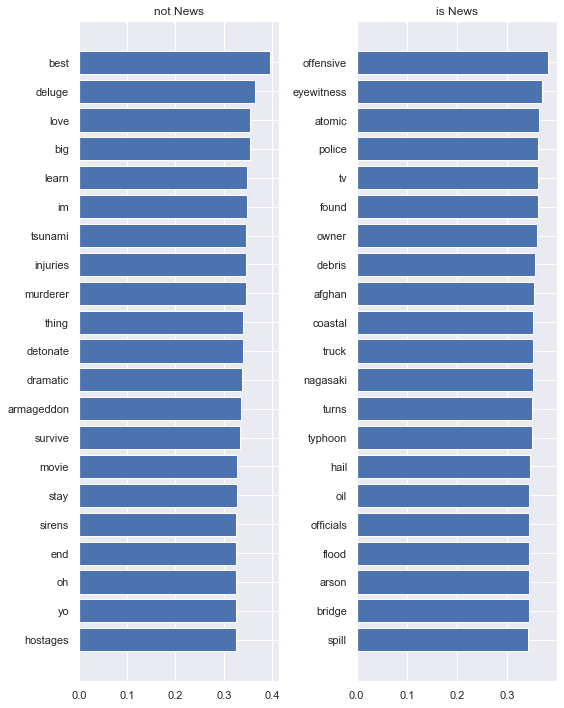

In [38]:
plt.figure(figsize = (8, 10))
plt.subplot(1, 2, 1)
plt.barh(ascend.sort_values(by = 'parameter', ascending = False).word,
         np.abs(ascend.sort_values(by = 'parameter', ascending = False).parameter))
plt.title('not News')
plt.subplot(1, 2, 2)
plt.barh(descend.sort_values(by = 'parameter', ascending = True).word,
         np.abs(descend.sort_values(by = 'parameter', ascending = True).parameter))
plt.title('is News')
plt.tight_layout()

### Reverse Engineer

In [39]:
def misclassified_tweets(label = 1):
    BoW_np = np.array(bag)
    x     = x_val[y_val == label]
    pred  = model.predict_classes(x).squeeze()
    x_mis = x[pred == (1 - label)]

    tweets = []
    
    for ele in x_mis:
        words = BoW_np[ele != 0].tolist()
        tweets.append(' '.join(words))
    return tweets

In [40]:
print('Test Dataset (not News) Misclassified')
misclassified_tweets(label = 0)

Test Dataset (not News) Misclassified


['rescue link animalrescue coastal german shared oc shepherd',
 'gt armageddon official NONE',
 'video watch oil spill mexico bp birthday NONE',
 'destroy NONE',
 'years making four masterpiece NONE',
 'bleeding started ear NONE',
 'seismic intensity sismo miyagi detectado japì jst NONE',
 'pulls somehow NONE',
 'injured NONE',
 'fatality',
 'gt everyone floods destroyed extreme soon starts servers load ends maintenance NONE',
 'earthquake drill',
 'hiroshima survivors eyewitness number history projects accounts gleaned oral NONE',
 'us nuclear years come fact reactor quick NONE',
 'area flooding reported ten po NONE',
 'injury stock hand floyd michael fantasy usatoday devalue NONE',
 'year warning plan heat friends wave visit NONE',
 'see hurricane guillermo NONE',
 'flood myanmar arrived bago NONE',
 'deluged heavy rainfall NONE',
 'performance incredible gollum NONE',
 'evacuate building ship abandon dealbreaker NONE',
 'photo bombed',
 'bioterrorism fight sir NONE',
 'government en